# CROSS VALIDATION : K FOLD

<br>

## Introduction

<br>
K-fold cross-validation is a special case of cross-validation where we iterate over a dataset set $k$ times. In each round, we split the dataset into $k$ parts (or folds): the $k^{th}$ fold is used for validation (test set), and the remaining $k - 1$ folds are merged into a training set for model fitting.

<br>
Just as in the hold-out method, in each iteration of k-fold we use a learning algorithm with fixed hyper-parameters to fit models to the training folds. This procedure will result in <b>$k$ different models fitted : these models were fit to distinct (yet partly overlapping) training sets and evaluated on non-overlapping test sets. Eventually, the generalization performace is computed as the arithmetic mean over the $k$ performance estimates</b>.

<br>
The main difference between the hold-out method is that <b>k-fold cross-validation uses all data for training and testing</b>. The idea behind this approach is to <b>reduce the pessimistic bias by using more training data</b> in contrast to setting aside a relatively large portion of the dataset as test data.


<img src="images/k-fold-summary.png" width="60%" height="60%">

In [1]:
# SETUP : importing

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
#import sklearn.linear_model as lm
import sklearn.neighbors as nbr
from sklearn.model_selection import KFold
import sklearn.metrics as mtr

import preprocessing as pre
import utilcompute as uc
from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_iris().data, load_iris().target) )
df = pd.DataFrame(data)
df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'species']

#print('df.shape[0] : ', df.shape[0])


In [3]:
#df.describe()

In [4]:
# DATA PREPROCESSING : deleting features

to_delete = []
cols = [c for c in df.columns.values.tolist() if (c not in to_delete)]
df = df[cols]

#print('columns : ', df.columns.values.tolist())

In [5]:
target = 'species'
if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [6]:
# DATA PREPROCESSING : features standardization

vif_dict = uc.compute_vif(df = df, features = features)
print('df : ')
print()
pprint(vif_dict)

print()

df_std = pre.standardize(df = df, included = features, excluded = target)

vif_dict = uc.compute_vif(df = df_std, features = features)
print('df_std : ')
print()
pprint(vif_dict)


df : 

{'petal length': 173.96896536339727,
 'petal width': 55.48868864572551,
 'sepal length': 264.7457109493044,
 'sepal width': 97.111605833803296}

df_std : 

{'petal length': 31.397291650719751,
 'petal width': 16.141563956997683,
 'sepal length': 7.1031134428332869,
 'sepal width': 2.0990386257420881}


In [7]:
# DATA PREPROCESSING : vif subset selection [reduces multicollinearity]

VIF = False

if (VIF):
    selected_features = uc.vif_best_subset_selection(
        vif_threshold = 5, 
        df = df_std, 
        features = features, 
        level = len(features), 
        debug = False
    )
    t = uc.concatenate(features, target)
    df_std = df_std[t]
    
    vif_dict = uc.compute_vif(df = df_std, features = selected_features)
    pprint(vif_dict)
else:
    selected_features = features


In [8]:
# DATA PREPROCESSING : final setup

df = df_std
features = selected_features

print(df_std.columns.values)

['petal length' 'petal width' 'sepal length' 'sepal width' 'species']


In [9]:
# GLOBAL PARAMETERS 

n_splits = 10

print('k (# of folds) : ', n_splits)


k (# of folds) :  10


In [10]:
columns = ['iteration', 'err_train', 'err_test']
results_df = pd.DataFrame(data = None, index = None, columns = columns)

kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :

    fold_train = df.iloc[train_positions]   
    fold_test = df.iloc[test_positions]  
    
    # if (k == 0):
    #    print('train indices : {0} - {1}'.format(fold_train.index.values[:3], fold_train.index.values[-3:]))
    #    print('test  indices : {0} - {1}'.format(fold_test.index.values[:3], fold_test.index.values[-3:]))
    #    print()

    #model = lm.LogisticRegression()
    model = nbr.KNeighborsClassifier(n_neighbors = 5)
    model.fit(fold_train[features], fold_train[target])

    y_pred_train = model.predict(fold_train[features])
    y_pred_test = model.predict(fold_test[features])

    #metrics_train = uc.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train)
    #metrics_test = uc.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test)
    
    acc_train = mtr.accuracy_score(y_true = fold_train[target], y_pred = y_pred_train, normalize = True, sample_weight = None)
    acc_test = mtr.accuracy_score(y_true = fold_test[target], y_pred = y_pred_test, normalize = True, sample_weight = None)

    values_dict = {
        'iteration' : k + 1,            
        #'err_train' : 1 - metrics_train['ACCURACY'],
        #'err_test' : 1 - metrics_test['ACCURACY'],
        'err_train' : 1 - acc_train,
        'err_test' : 1 - acc_test,
    }

    results_index = k
    results_df.loc[results_index] = values_dict     

results_df = results_df.astype(dtype = 'float')
#print(results_df)


In [11]:
print()
print('train | err mean : ', results_df['err_train'].mean())
print('train | err std  : ', results_df['err_train'].std())

print()
print('test  | err mean : ', results_df['err_test'].mean())
print('test  | err std  : ', results_df['err_test'].std())



train | err mean :  0.04
train | err std  :  0.0140545673785261

test  | err mean :  0.07333333333333332
test  | err std  :  0.0857789291805279


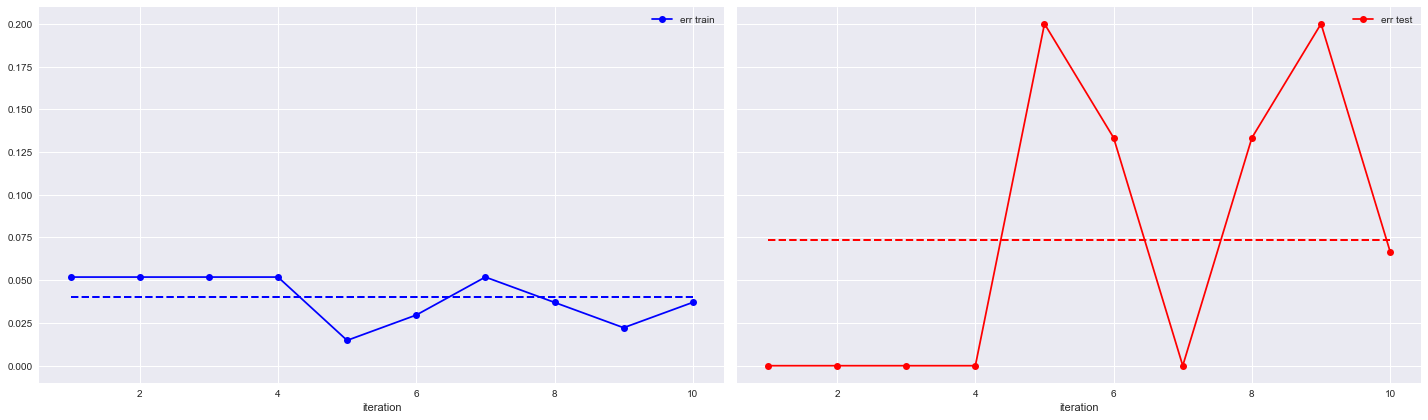

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 6), sharey = True) 

it_min = results_df['iteration'].min()
it_max = results_df['iteration'].max()

err_train_mean = results_df['err_train'].mean()
err_test_mean = results_df['err_test'].mean()

axs[0].plot(results_df['iteration'], results_df['err_train'], color = 'blue', label = 'err train', marker = 'o')
axs[0].plot( (it_min, it_max), (err_train_mean, err_train_mean), color = 'blue', lw = 2, linestyle = '--')
axs[0].set_xlabel('iteration')
axs[0].legend(loc = 'best')

axs[1].plot(results_df['iteration'], results_df['err_test'], color = 'red', label = 'err test', marker = 'o')
axs[1].plot( (it_min, it_max), (err_test_mean, err_test_mean), color = 'red', lw = 2, linestyle = '--')
axs[1].set_xlabel('iteration')
axs[1].legend(loc = 'best')

#y_lim = (0,0)
#max_y_range = y_lim[1] - y_lim[0]
#for ax in axs:
#    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
#    if (y_range > max_y_range):
#        max_y_range = y_range
#        y_lim = ax.get_ylim()
#for ax in axs:   
#    ax.set_ylim(y_lim)

plt.tight_layout()
plt.show()


## Considerations

<br>
K-fold cross-validation guarantees that each data point will be selected for the training fold in $k - 1$ iterations, and for the validation fold once and only once (in contrast to repeated hold-out, where some samples may never be part of the test set).

<br>
This mechanism makes it possible to have <b>large (yet partly overlapping) training sets, and non-overlapping test sets; this last characteristic of k-fold cv addresses another issue of repeated hold-out : the repeated use of samples in the test sets</b> yields to performance estimates that become dependent between rounds, this dependence can be problematic for statistical comparisons.

<br>
<b>Stratification is not usually part of the algorithm, unless we are to perform sub-sampling from the original dataset</b>; in that case, being sub-sampling part of the data pre-processing phase, it has to be executed during cross-validation and we would considerate sub-sampling with stratification: in each of the $k$ iterations, the data available will be first sub-sampled, and the resulting points eventually splitted into training and validation sets.                                           

<br>
<b>Further questions/issues</b> :

<br>
<ul style="list-style-type:square">
    <li>
        computationally expensive 
    </li>
    <br>
    <li>
        variance tends to be high
    </li>
    <br>
    <li>
        the choice of K
    </li>
</ul>

<br>
<table  align = "left" bgcolor="#00FF00">
    <tr>
        <td><b>Note</b> : </td><td>see Cross Validation - K Fold - 2 folds</td>
    </tr>
    <tr>
        <td></td><td>see Cross Validation - K fold - N folds</td>
    </tr>
</table>

## References

<br>
<ul style="list-style-type:square">
    <li>
         Sebastian Raschka - 
         <a href="https://bit.ly/2LEwbSN">
         Model evaluation, model selection, and algorithm selection in machine learning - Part III</a>        
    </li>
</ul>